In [1]:
from scipy.constants import epsilon_0
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from SimPEG.Utils import ndgrid, mkvc
from ipywidgets import *

# Setup:

Sphere in a wholespace with a constant, uniform electric field

Parameters:

 - sigma_0 : conductivity of the background
 - sigma_1 : conductivity of the sphere

http://www.3ptscience.com/app/DCresistivity

# Parameters for the sphere Problem


In [2]:
sig0 = 10.        # conductivity of the wholespace
sig1 = 100.           # conductivity of the sphere
R    = 50.          # radius of the sphere
E0   = 1.           # inducing field strength
xr = np.linspace(-2.*R, 2.*R, 100)
yr = xr.copy()
zr = np.r_[0] # identical to saying `zr = np.array([0])`
XYZ = ndgrid(xr,yr,zr) #Half-Space Definition
# d    = 2           # mesh spacing

In [3]:
r  = lambda x,y,z: np.sqrt(x**2.+y**2.+z**2.)
sigf = lambda sig0,sig1: (sig1-sig0)/(sig1+2.*sig0)

In [4]:
#Define the conductivity for each point of the space
def get_Conductivity(XYZ,sig0,sig1,R):
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    r_view=r(x,y,z)
    
    ind0= (r_view>R)
    ind1= (r_view<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Sigma = np.zeros_like(x)
    
    Sigma[ind0]=sig0
    Sigma[ind1]=sig1
    
    return Sigma

# Potentials Computation

In [5]:
# assumes an x-oriented inducing field
# and that the sphere is at the origin
def get_Potential(XYZ,sig0,sig1,R,E0): 
    
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    
    sig_cur= sigf(sig0,sig1)
    
    r_cur = r(x,y,z)
    
    ind0 = (r_cur > R)
    ind1 = (r_cur <= R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Vt = np.zeros_like(x)
    Vp = np.zeros_like(x)
    Vs = np.zeros_like(x)
    
    Vt[ind0] = -E0*x[ind0]*(1.-sig_cur*R**3./r_cur[ind0]**3.) # outside the sphere
    Vt[ind1] = -E0*x[ind1]*3.*sig0/(sig1+2.*sig0)
    
    Vp = - E0*x
    
    Vs = Vt - Vp
    
    return Vt,Vp,Vs

In [6]:
#def get_Primary_Potential(XYZ,sig0,sig1,R,E0):
#   x = XYZ[:,0]
#   return - E0*x

<function __main__.plot_Potentials>

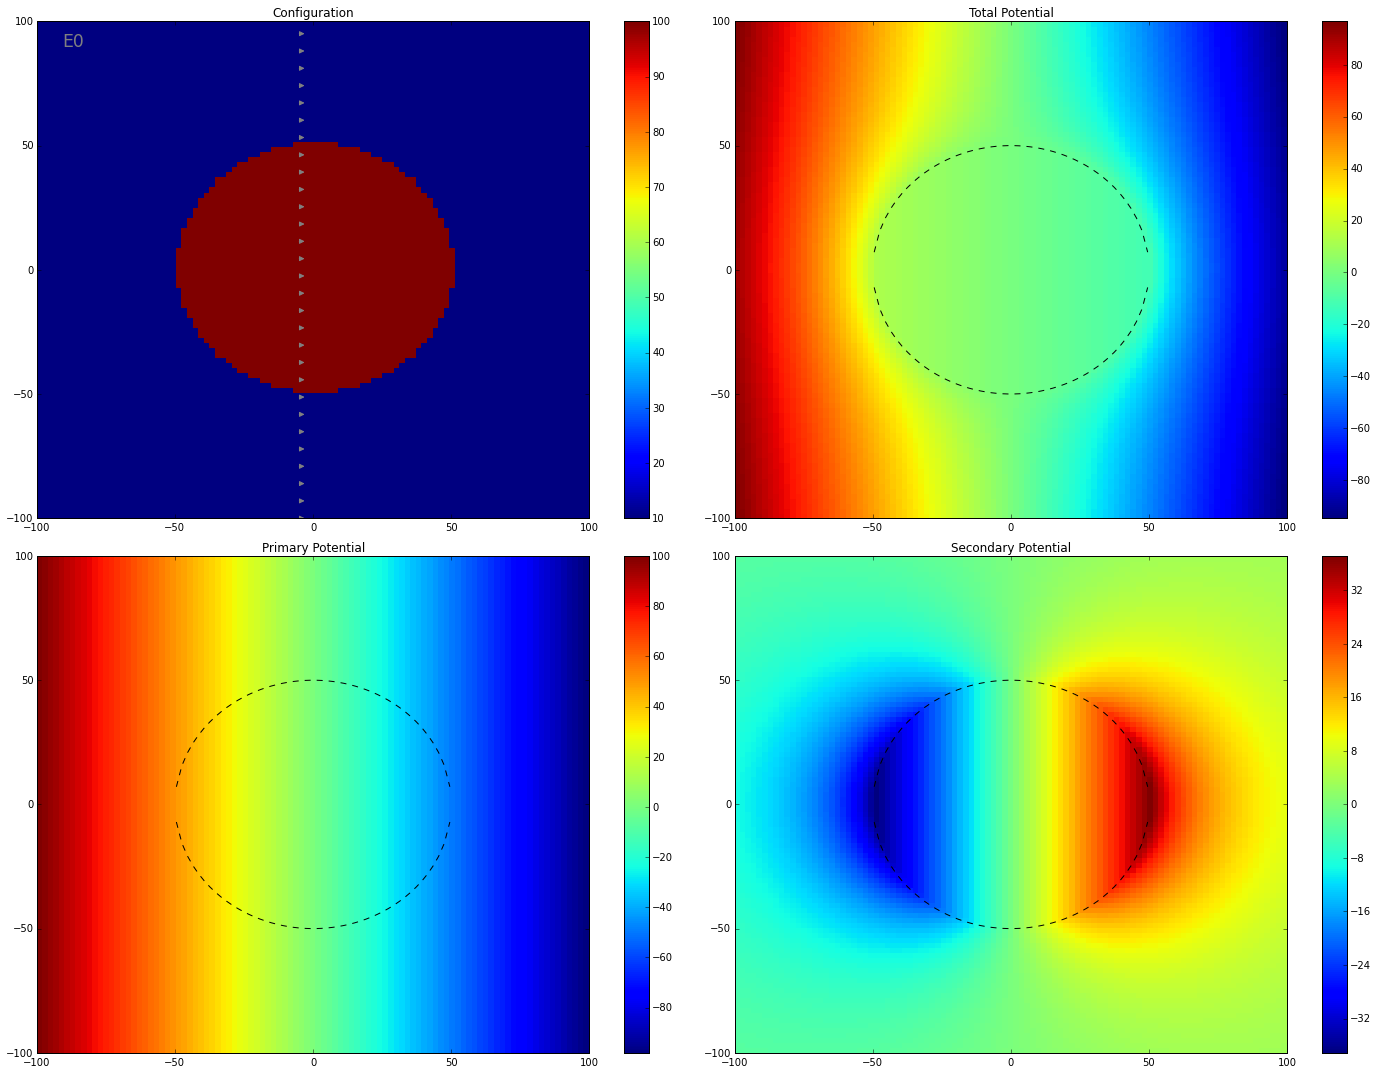

In [22]:
# Interactive tool to visualise the primary, secondary and total potentials

R_slider = FloatSlider(min=0., max =50., step=10.,value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)

def plot_Potentials(R,sig1,sig0):
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Vt,Vp,Vs = get_Potential(XYZ,sig0,sig1,R,E0)
    
    Ep = np.zeros(shape=(len(Sigma),3))
    Ep[:,0] = E0
    #Vp = get_Primary_Potential(XYZ,sig0,sig1,R,E0)

    xcirc = xr[np.abs(xr) <= R]

    fig,ax = plt.subplots(2,2,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])


    ax[1].pcolor(xr,yr,Vp.reshape(xr.size,yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Primary Potential')
    plt.colorbar(ax[1].pcolor(xr,yr,Vp.reshape(xr.size, yr.size)),ax=ax[1])

    ax[2].pcolor(xr,yr,Vt.reshape(xr.size,yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Potential')
    plt.colorbar(ax[2].pcolor(xr,yr,Vt.reshape(xr.size, yr.size)),ax=ax[2])


    ax[3].pcolor(xr,yr,Vs.reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Secondary Potential')
    plt.colorbar(ax[3].pcolor(xr,yr,Vs.reshape(xr.size, yr.size)),ax=ax[3])


    plt.tight_layout()
    
interact(plot_Potentials, R=R_slider, sig1=S1_slider, sig0=S0_slider)

# Electric Field Computation

In [13]:
#Function that returns the primary and total electric fields

def get_ElectricField (XYZ,sig0,sig1,R,E0):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
        
    Ep = np.zeros(shape=(len(x),3))
    Ep[:,0] = E0
    
    Et = np.zeros(shape=(len(x),3))
    
    Et[ind0,0] = E0 + E0*R**3./(r_cur[ind0]**5.)*sigf(sig0,sig1)*(2.*x[ind0]**2.-y[ind0]**2.-z[ind0]**2.);
    Et[ind0,1] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*y[ind0]*sigf(sig0,sig1);
    Et[ind0,2] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*z[ind0]*sigf(sig0,sig1);

    Et[ind1,0] = 3.*sig0/(sig1+2.*sig0)*E0;
    Et[ind1,1] = 0.;
    Et[ind1,2] = 0.;
    
    Es = Et - Ep
    
    return Et, Ep, Es


<function __main__.plot_ElectricField>

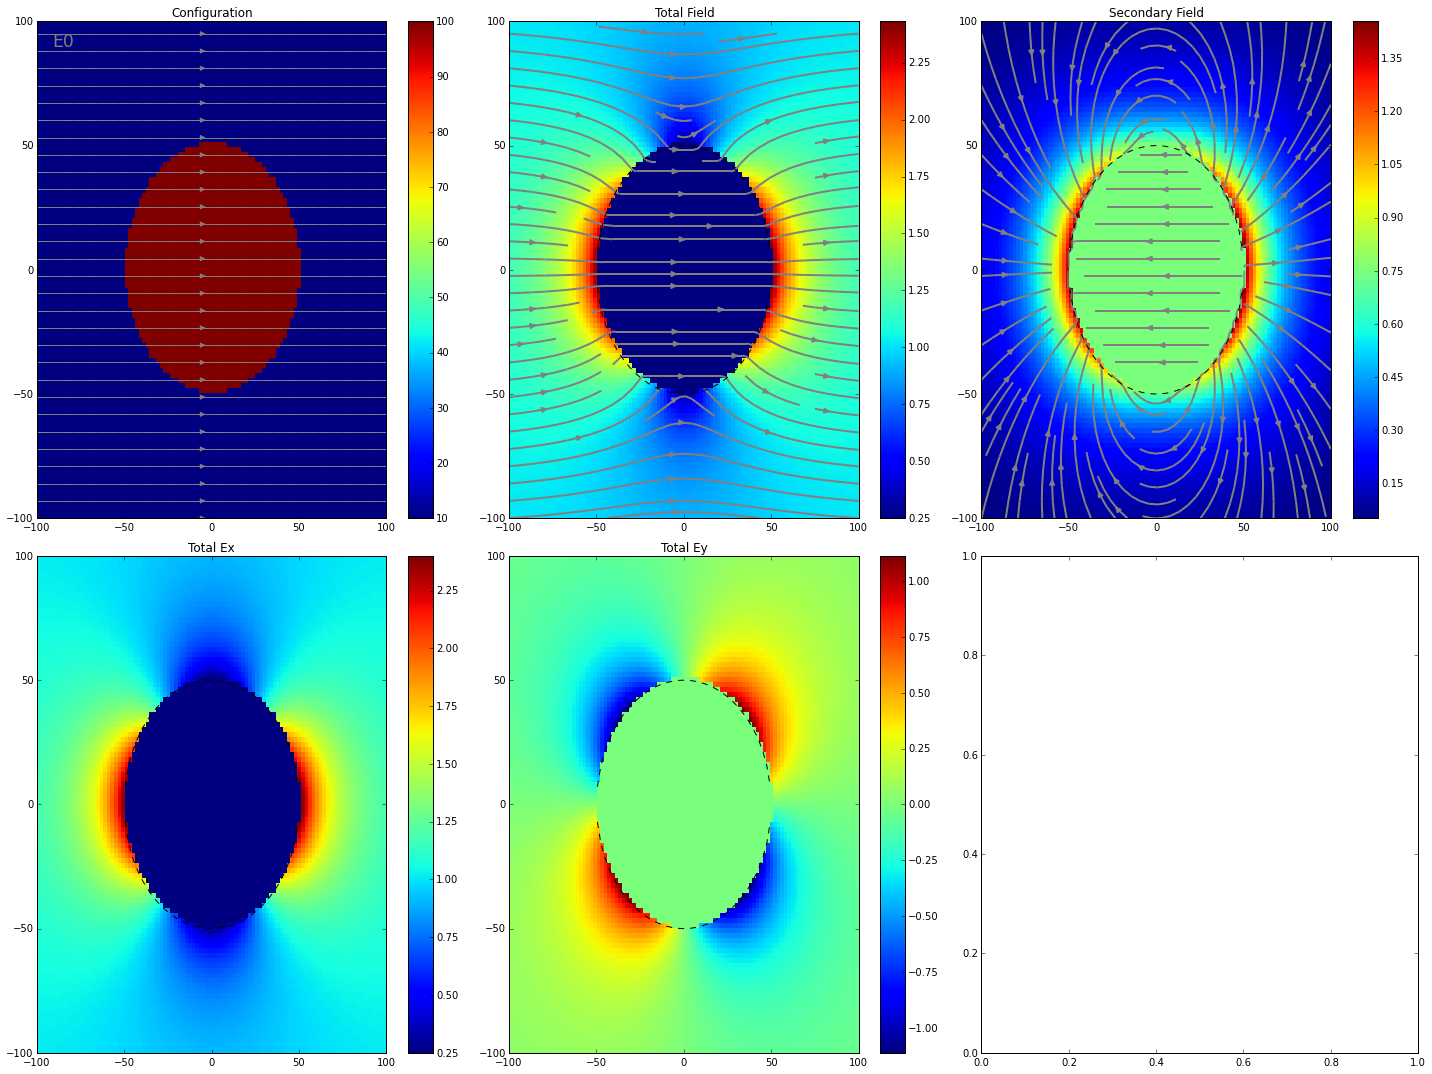

In [29]:
#Interavtice visualisation of the Electric Field

R_slider = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)
#PlotOpt=ToggleButtons(options=['total','secondary'])

#PlotOpt would need to be passed to the function in the interact. You could define something like:

#   if PlotOpt is 'total':
 #         Jplot = Jtotal
# elif PlotOpt is 'secondary':
#          Jplot = Jsecondary

def plot_ElectricField(R,sig1,sig0,E0):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    
    xcirc = xr[np.abs(xr) <= R]
    
    EtXr = Et[:,0].reshape(xr.size, yr.size)
    EtYr = Et[:,1].reshape(xr.size, yr.size)
    EtZr = Et[:,2].reshape(xr.size, yr.size)
    
    ESXr = Es[:,0].reshape(xr.size, yr.size)
    ESYr = Es[:,1].reshape(xr.size, yr.size)
    ESZr = Es[:,2].reshape(xr.size, yr.size)
    
    fig,ax = plt.subplots(2,3,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    
    ax[2].pcolor(xr,yr,np.sqrt(Et[:,0]**2+Et[:,1]**2).reshape(xr.size, yr.size))
    plt.colorbar(ax[2].pcolor(xr,yr,np.sqrt(Et[:,0]**2+Et[:,1]**2).reshape(xr.size, yr.size)),ax=ax[2])
    ax[2].streamplot(xr,yr,EtXr,EtYr,color='gray',linewidth=2.)#angles='xy',scale_units='xy',scale=0.05)
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Field')
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])

    ax[1].pcolor(xr,yr,Et[:,0].reshape(xr.size, yr.size))
    plt.colorbar(ax[1].pcolor(xr,yr,Et[:,0].reshape(xr.size, yr.size)),ax=ax[1])
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Total Ex')
    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])


    ax[3].pcolor(xr,yr,Et[:,1].reshape(xr.size,yr.size))
    plt.colorbar(ax[3].pcolor(xr,yr,Et[:,1].reshape(xr.size, yr.size)),ax=ax[3])
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Total Ey')
    ax[3].set_xlim([xr.min(),xr.max()])
    ax[3].set_ylim([yr.min(),yr.max()])


    ax[4].pcolor(xr,yr,np.sqrt(Es[:,1]**2+Es[:,0]**2).reshape(xr.size,yr.size))
    plt.colorbar(ax[4].pcolor(xr,yr,np.sqrt(Es[:,1]**2+Es[:,0]**2).reshape(xr.size, yr.size)),ax=ax[4])
    ax[4].streamplot(xr,yr,ESXr,ESYr,color='gray',linewidth=2.)#,angles='xy',scale_units='xy',scale=0.05)
    ax[4].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[4].set_title('Secondary Field')
    ax[4].set_xlim([xr.min(),xr.max()])
    ax[4].set_ylim([yr.min(),yr.max()])


    plt.tight_layout()
    
interact(plot_ElectricField, R=R_slider, sig1=S1_slider,sig0=S0_slider,E0=E0_slider)

# Current Density

In [26]:
#Computation of the current Density

def get_Current(XYZ,sig0,sig1,R,Et,Ep,Es):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    
    r_cur=r(x,y,z)
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Jt = np.zeros(shape=(len(x),3))
    J0 = np.zeros(shape=(len(x),3))
    Js = np.zeros(shape=(len(x),3))
    
    Jp = sig0*Ep
    
    Jt[ind0,:] = sig0*Et[ind0,:]   
    Jt[ind1,:] = sig1*Et[ind1,:]

    
    Js[ind0,:] = sig0*Es[ind0,:]
    Js[ind1,:] = sig1*Es[ind1,:]
    
    return Jt,Jp,Js
    

<function __main__.plot_Currents>

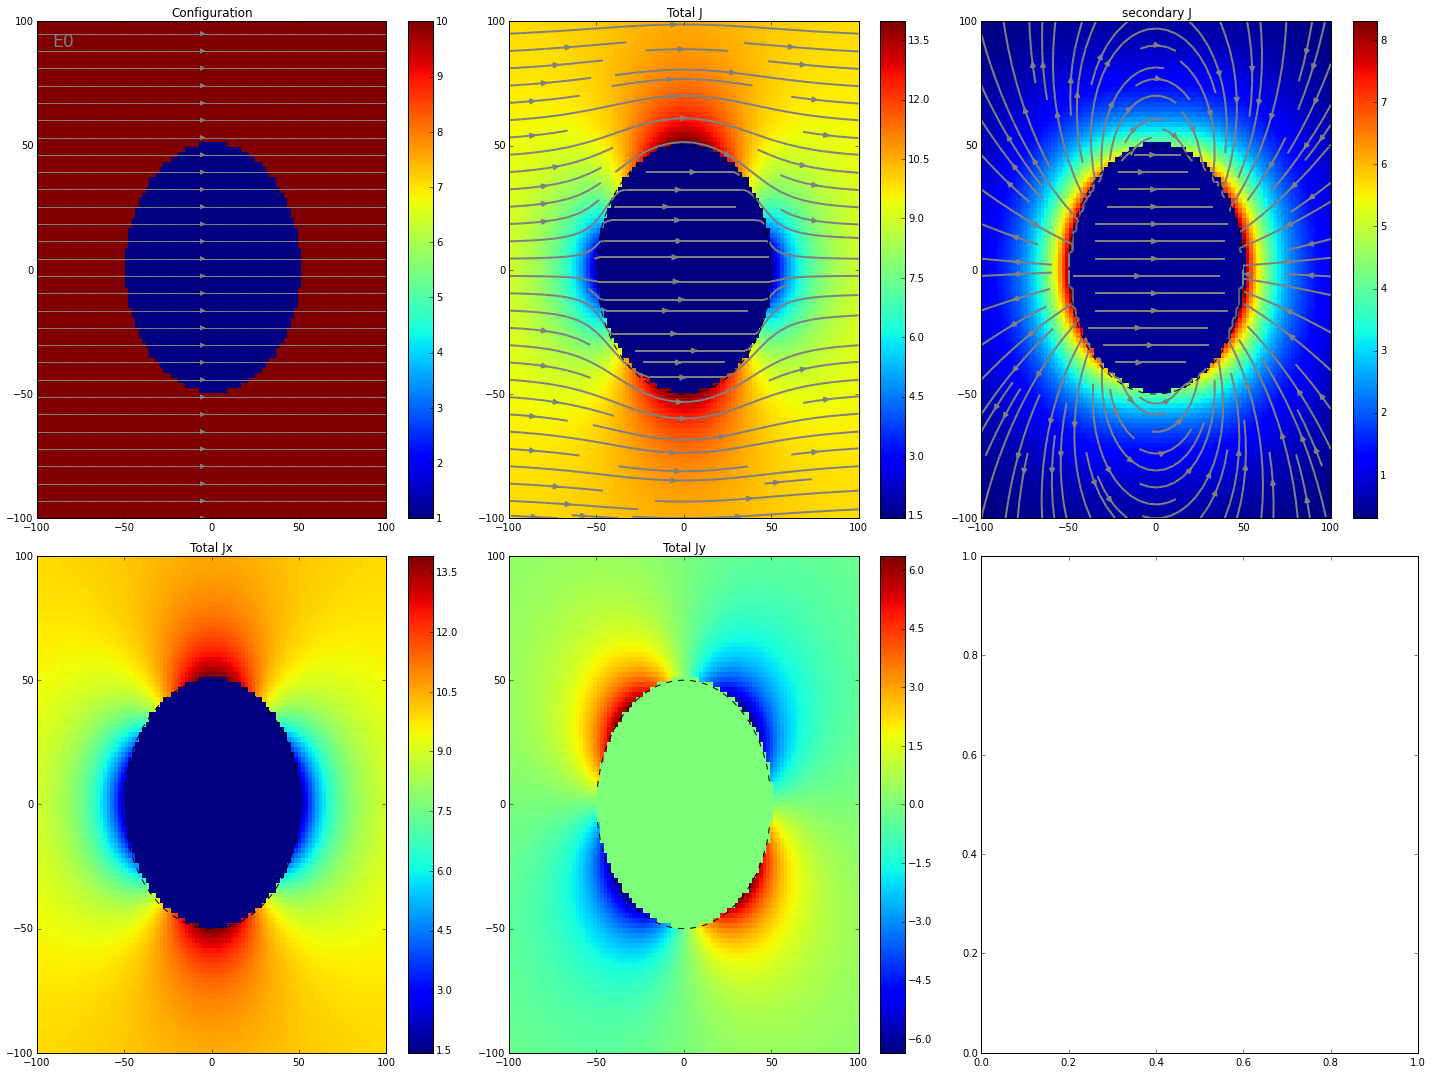

In [28]:
#Interavtice visualisation of the current density

R_slider = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=1.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)

def plot_Currents(R,sig1,sig0,E0):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    Jt,Jp,Js = get_Current(XYZ,sig0,sig1,R,Et,Ep,Es)
    
    xcirc = xr[np.abs(xr) <= R]
    
    JtXr = Jt[:,0].reshape(xr.size, yr.size)
    JtYr = Jt[:,1].reshape(xr.size, yr.size)
    JtZr = Jt[:,2].reshape(xr.size, yr.size)
    #JtX,JtY,JtZ=JtXr[::10,::10], JtYr[::10,::10], JtZr[::10,::10]
    
    
    JsXr = Js[:,0].reshape(xr.size, yr.size)
    JsYr = Js[:,1].reshape(xr.size, yr.size)
    JsZr = Js[:,2].reshape(xr.size, yr.size)
    #JsX,JsY,JsZ=JsXr[::10,::10], JsYr[::10,::10], JsZr[::10,::10]
    
    fig,ax = plt.subplots(2,3,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    
    ax[2].pcolor(xr,yr,np.sqrt(Jt[:,0]**2+Jt[:,1]**2).reshape(xr.size, yr.size))
    plt.colorbar(ax[2].pcolor(xr,yr,np.sqrt(Jt[:,1]**2+Jt[:,0]**2).reshape(xr.size, yr.size)),ax=ax[2])
    ax[2].streamplot(xr,yr,JtXr,JtYr,color='gray',linewidth=2.)#,angles='xy',scale_units='xy',scale=1)
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])
    ax[2].set_title('Total J')

    ax[1].pcolor(xr,yr,Jt[:,0].reshape(xr.size, yr.size))
    plt.colorbar(ax[1].pcolor(xr,yr,Jt[:,0].reshape(xr.size, yr.size)),ax=ax[1])
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Total Jx')

    ax[3].pcolor(xr,yr,Jt[:,1].reshape(xr.size,yr.size))
    plt.colorbar(ax[3].pcolor(xr,yr,Jt[:,1].reshape(xr.size, yr.size)),ax=ax[3])
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Total Jy')

    ax[4].pcolor(xr,yr,np.sqrt(Js[:,1]**2+Js[:,0]**2).reshape(xr.size,yr.size))
    plt.colorbar(ax[4].pcolor(xr,yr,np.sqrt(Js[:,1]**2+Js[:,0]**2).reshape(xr.size, yr.size)),ax=ax[4])
    ax[4].streamplot(xr,yr,JsXr,JsYr,color='gray',linewidth=2.)#angles='xy',scale_units='xy',scale=1)
    ax[4].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[4].set_xlim([xr.min(),xr.max()])
    ax[4].set_ylim([yr.min(),yr.max()])
    ax[4].set_title('secondary J')
    

    plt.tight_layout()
    
interact(plot_Currents, R=R_slider, sig1=S1_slider, sig0=S0_slider,E0=E0_slider)

# Charge Accumulation computation

In [17]:
def get_Charges(XYZ,sig0,sig1,R,Et):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)
    
    ind2= (r_cur>R)
    ind1= (r_cur<R)
    ind0=(r_cur == R)
    
    assert (ind0 + ind1 + ind2).all(), 'Some indicies not included'
    
    Q = np.zeros_like(x)
    
    Q= reduce(np.add,np.gradient(Et))
    
    #Q[ind1] = 0
    #Q[ind2] = 0
    #Q[ind0] = E0*R**3.*sigf(sig0,sig1)*((4.*x[ind0]*r_cur[ind0]**5.-5.*x[ind0]*(2.*x[ind0]**2.*-y[ind0]**2-z[ind0]**2.)*r_cur[ind0]**3.)+(2.*x[ind0]*r_cur[ind0]**5.-5.*y[ind0]*3.*x[ind0]*y[ind0]*r_cur[ind0]**3.)+(3.*x[ind0]*r_cur[ind0]**5.-5.*z[ind0]*3.*x[ind0]*z[ind0]*r_cur[ind0]**3.))/r_cur[ind0]**10.
    
    return Q

In [18]:
Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
Q = get_Charges(XYZ,sig0,sig1,R,Et)
print Q.shape

(10000, 3)


NameError: global name 'xrr' is not defined

<function __main__.plot_Charges>

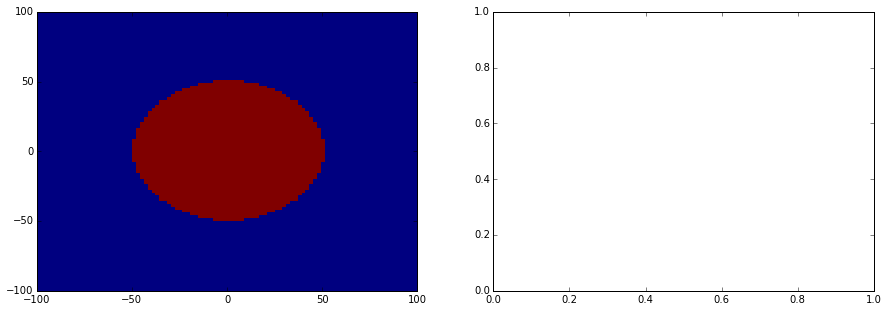

In [19]:
#Interavtice visualisation of the charge accumulation

R_slider = FloatSlider(min=0., max =50., step=10., value=50.)
S_slider = FloatSlider(min=1., max =100., step=1.,value=100.)

def plot_Charges(R,sig1):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    Q = get_Charges(XYZ,sig0,sig1,R,Et)
    
    xcirc = xr[np.abs(xr) <= R]
    
    fig,ax = plt.subplots(1,2,figsize=(15,5))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    
    ax[1].pcolor(xr,yr,np.sqrt(Q[:,0]**2+Q[:,1]**2+Q[:,2]**2).reshape(xr.size, yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Total Q')

    plt.tight_layout()
    
interact(plot_Charges, R=R_slider, sig1=S_slider)

In [ ]:
def divergence(F):
    """ compute the divergence of n-D scalar field `F` """
    return reduce(np.add,np.gradient(F))

In [99]:
Q= divergence(Et)

In [100]:
Q.shape

(10000, 3)

In [101]:
Q[0,0]

-0.96739028124900162

In [120]:
help(plt.streamplot)

Help on function streamplot in module matplotlib.pyplot:

streamplot(x, y, u, v, density=1, linewidth=None, color=None, cmap=None, norm=None, arrowsize=1, arrowstyle=u'-|>', minlength=0.1, transform=None, zorder=1, hold=None)
    Draws streamlines of a vector flow.
    
        *x*, *y* : 1d arrays
            an *evenly spaced* grid.
        *u*, *v* : 2d arrays
            x and y-velocities. Number of rows should match length of y, and
            the number of columns should match x.
        *density* : float or 2-tuple
            Controls the closeness of streamlines. When `density = 1`, the domain
            is divided into a 30x30 grid---*density* linearly scales this grid.
            Each cell in the grid can have, at most, one traversing streamline.
            For different densities in each direction, use [density_x, density_y].
        *linewidth* : numeric or 2d array
            vary linewidth when given a 2d array with the same shape as velocities.
        *color* : m